In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')

In [12]:
df = pd.read_csv('sdss_100k_galaxy_form_burst.csv', delimiter=' ') # adjust filename if needed
# Check if the data is still in a single column and needs splitting
if df.shape[1] == 1 and '#Table1' in df.columns:
    # Assuming the first row is a header and the rest are data rows
    header = df.iloc[0, 0].split(',')
    data_rows = df.iloc[1:, 0].str.split(',', expand=True)
    data_rows.columns = header
    df = data_rows
print("Shape:", df.shape)
df.head()

Shape: (9710, 43)


,objid,specobjid,ra,dec,u,g,r,i,z,modelFlux_u,...,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,class,subclass,redshift,redshift_err
1,1237646587710669400,8175185722644649984,82.0386790197966,0.847177136346427,21.73818,20.26633,19.32409,18.64037,18.23833,2.007378,...,19.43575,0.09995142,0.3118636,0.2893703,0.270588,0.1871822,GALAXY,STARFORMING,0.06774854,1.485608E-05
2,1237646588247540577,8175186822156277760,82.138894235229,1.06307163479155,20.66761,19.32016,18.67888,18.24693,18.04122,5.403369,...,18.85012,0.3665494,0.5168757,0.5174466,0.5522967,0.6369656,GALAXY,STARFORMING,0.1051184,9.869399E-06
3,1237646588247540758,8175187097034184704,82.028510297136,1.10400342592331,23.63531,21.19671,19.92297,19.31443,18.68396,0.2956932,...,19.42235,0.05,0.4171365,0.5069503,0.5498811,0.3701658,GALAXY,STARFORMING,0.2340893,2.968146E-05
4,1237648702973083853,332152325571373056,198.544469237915,-1.09705896364626,20.12374,18.4152,17.47202,17.05297,16.72423,8.920645,...,18.03204,0.3107628,0.3568271,0.3893448,0.3881598,0.4166596,GALAXY,STARFORMING,0.110825,3.046765E-05
5,1237648702973149350,332154249716721664,198.70686354093,-1.04621683165572,-9999,-9999,18.37762,18.13383,17.78497,0,...,19.0288,-9999,-9999,0.05,0.05,0.1499728,GALAXY,STARFORMING,0.136658,2.140523E-05


In [13]:
print("Columns:", list(df.columns))
df.isnull().sum().sum()

Columns: ['objid', 'specobjid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'modelFlux_u', 'modelFlux_g', 'modelFlux_r', 'modelFlux_i', 'modelFlux_z', 'petroRad_u', 'petroRad_g', 'petroRad_i', 'petroRad_r', 'petroRad_z', 'petroFlux_u', 'petroFlux_g', 'petroFlux_i', 'petroFlux_r', 'petroFlux_z', 'petroR50_u', 'petroR50_g', 'petroR50_i', 'petroR50_r', 'petroR50_z', 'psfMag_u', 'psfMag_r', 'psfMag_g', 'psfMag_i', 'psfMag_z', 'expAB_u', 'expAB_g', 'expAB_r', 'expAB_i', 'expAB_z', 'class', 'subclass', 'redshift', 'redshift_err']


np.int64(22)

In [34]:
if 'subclass' not in df.columns:
    raise ValueError("Column 'subclass' not found! Available columns:", df.columns.tolist())
df = df.dropna(subset=['subclass'])
# Create a temporary column to store original subclass values before encoding
df['subclass_original'] = df['subclass'].astype(str)
df = df[df['subclass_original'].str.lower() != 'nan']
df['subclass'] = df['subclass'].astype('category').cat.codes
print("Label mapping:")
print(df[['subclass_original', 'subclass']].drop_duplicates())

Label mapping:
   subclass_original  subclass
1                  1         1
25                 0         0


In [31]:
df.describe()

,u,subclass
count,8633.000000,8633.000000
mean,19.341355,0.770648
std,0.975298,0.420441
min,16.902000,0.000000
25%,18.759820,1.000000
50%,19.273490,1.000000
75%,19.808450,1.000000
max,21.954920,1.000000


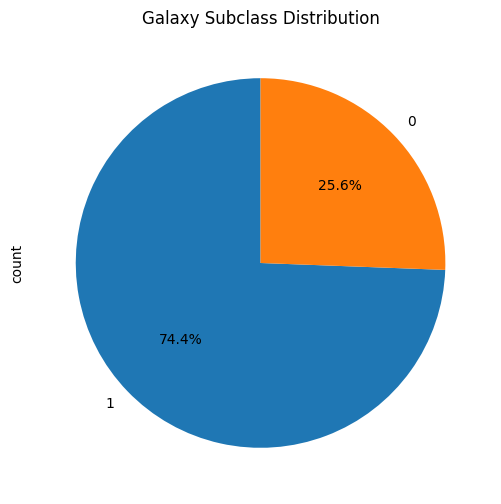

In [15]:
df.describe(include='all').T
plt.figure(figsize=(8,6))
df['subclass'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Galaxy Subclass Distribution')
plt.show()

In [36]:
df['subclass'] = df['subclass'].astype('category')

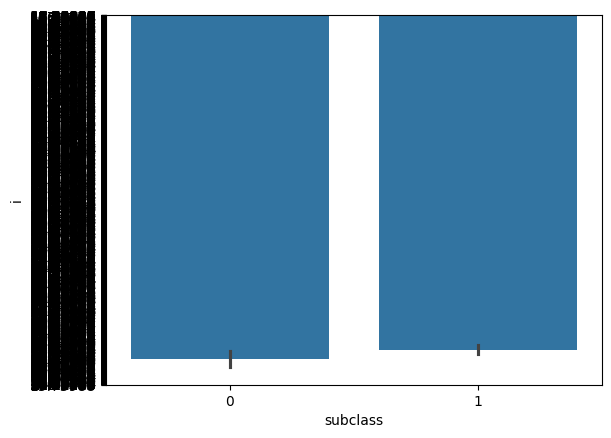

In [37]:
sns.barplot(x='subclass', y='i', data=df)
plt.show()


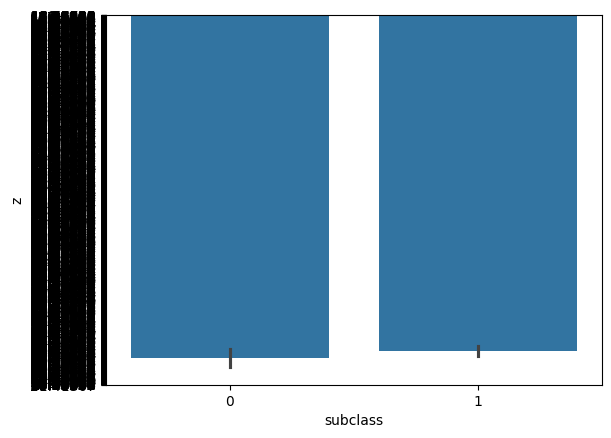

In [38]:
sns.barplot(x='subclass', y='z', data=df)
plt.show()


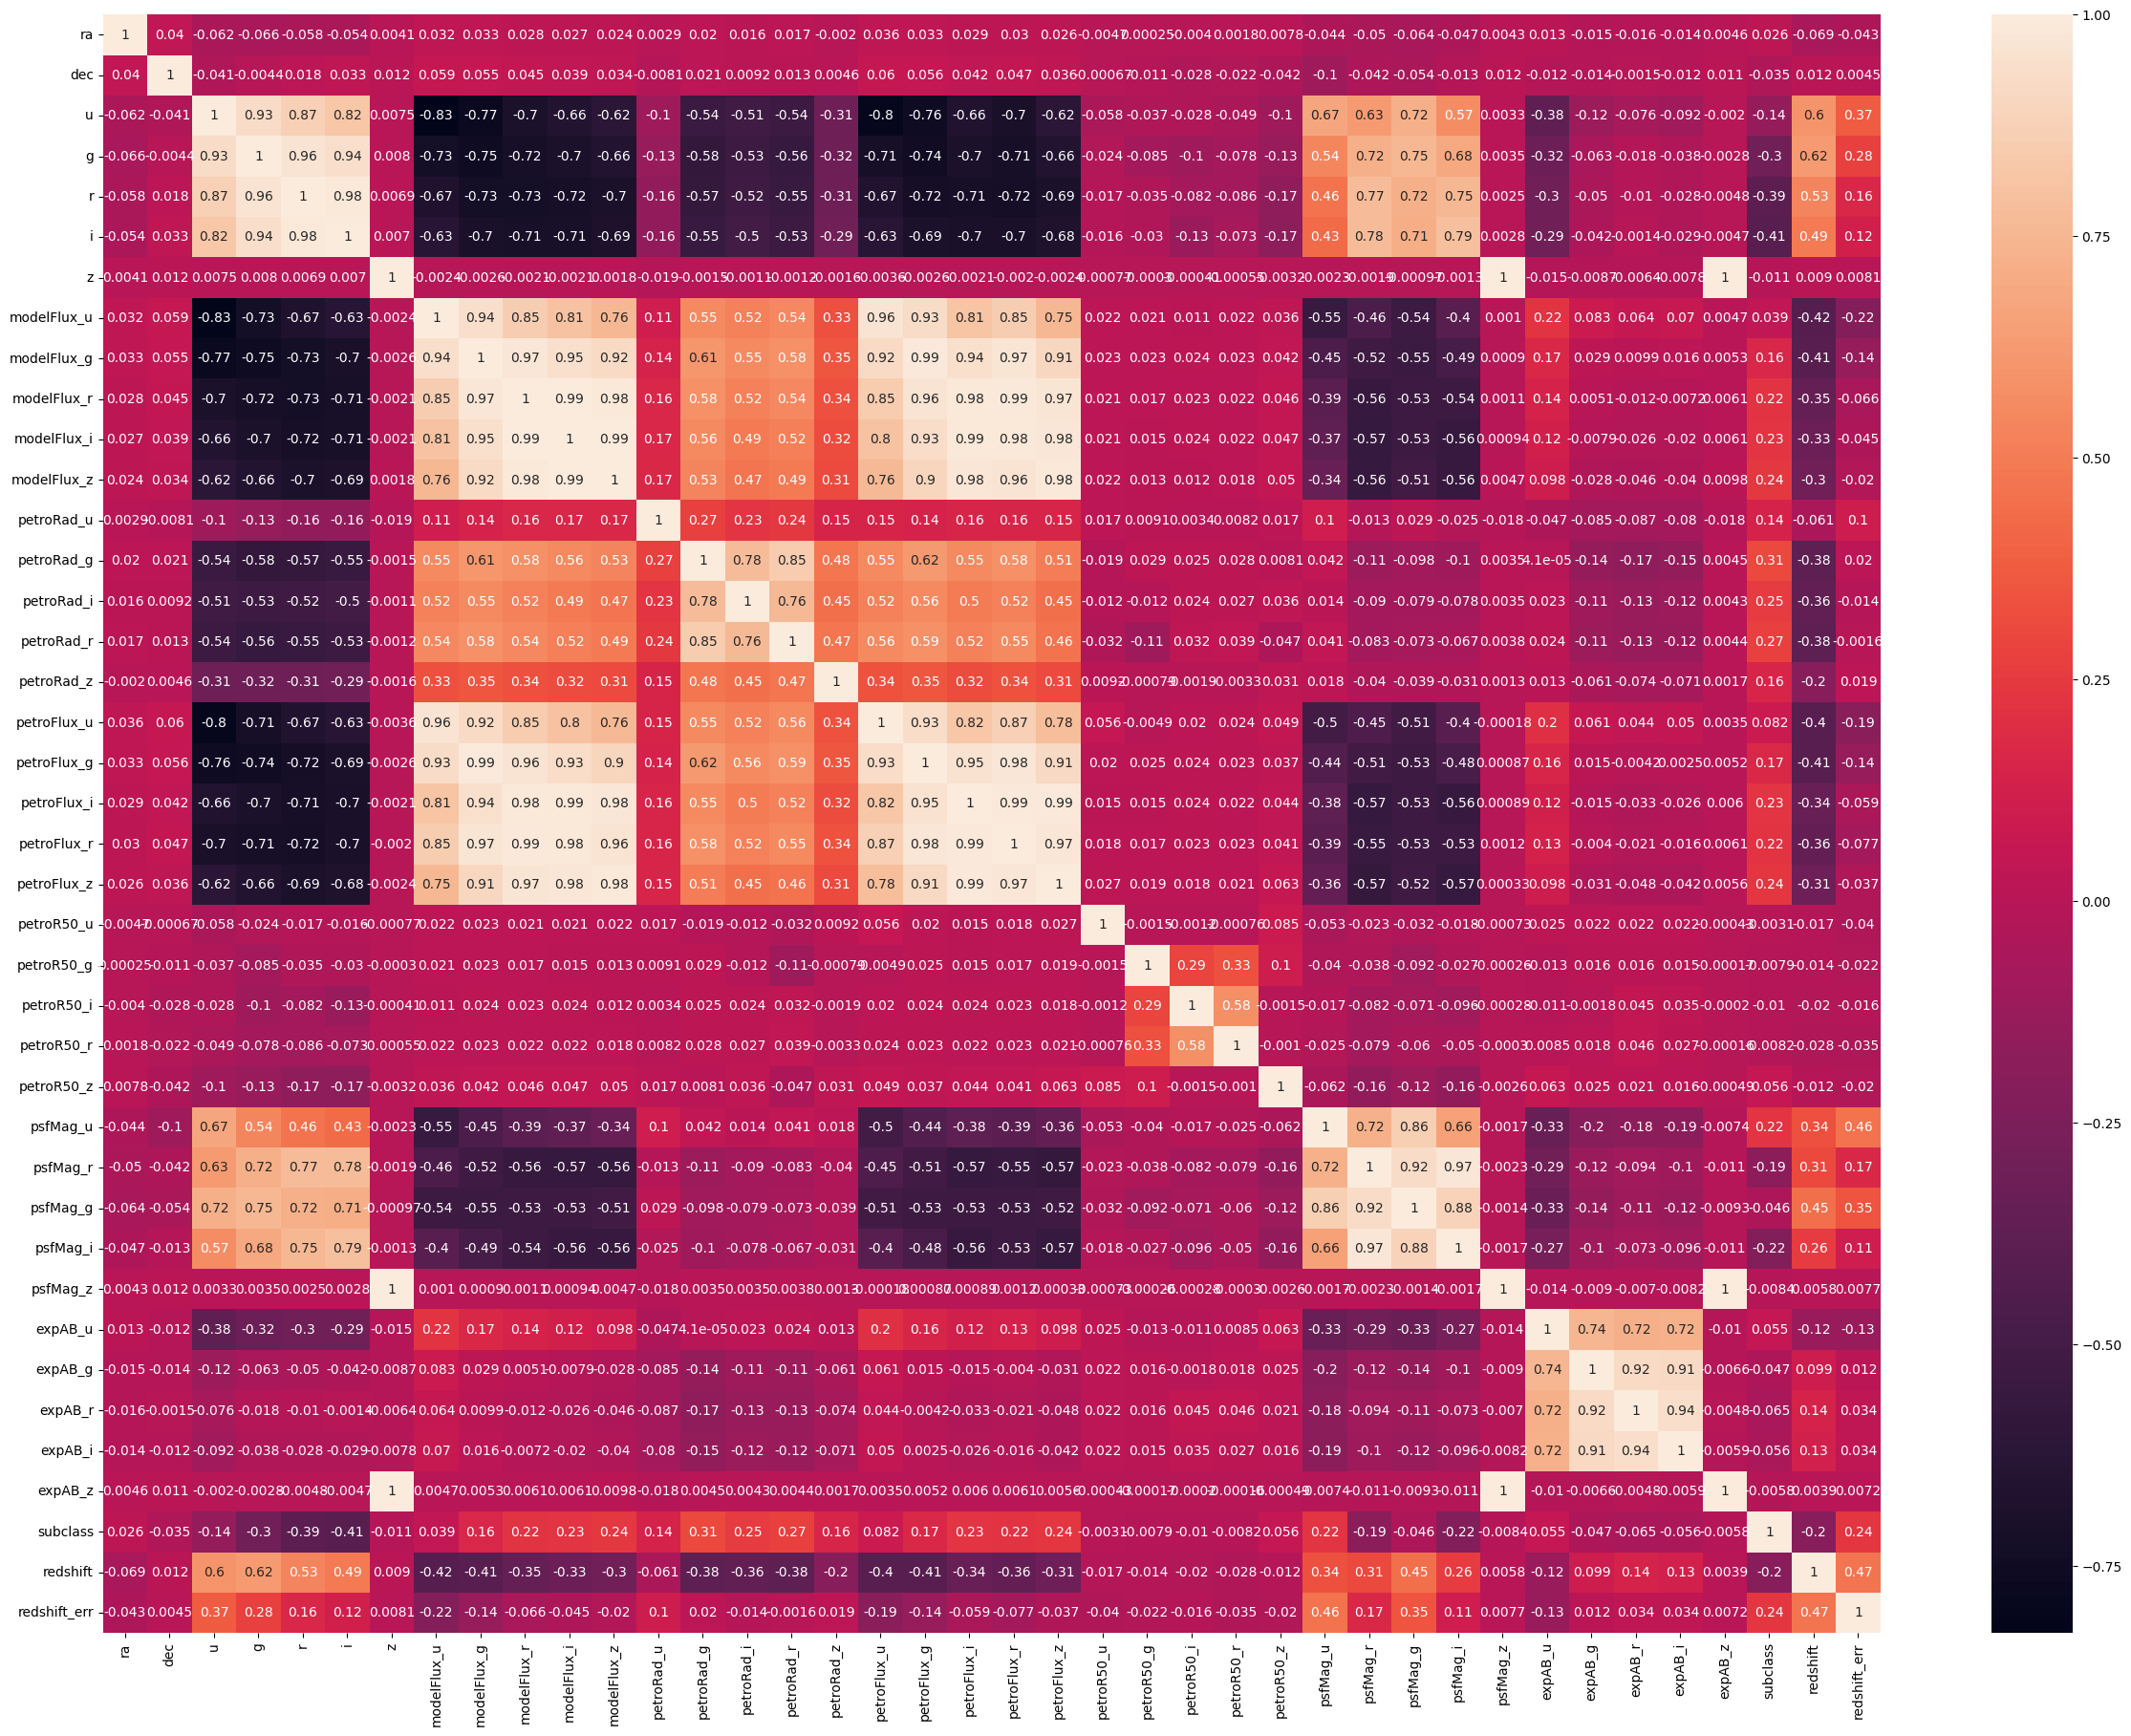

In [40]:
plt.figure(figsize=(30, 22))
# Drop non-numeric columns before calculating correlation
numeric_df = df.drop(['objid', 'specobjid', 'class', 'subclass_original'], axis=1)
sns.heatmap(numeric_df.corr(), annot=True)
plt.show()

0.75    19.80845
0.25    18.75982
Name: u, dtype: float64
19.80845
18.75982
1.0486299999999993
21.381394999999998
17.186875


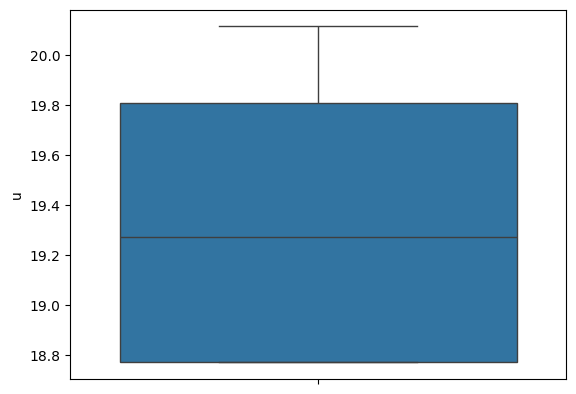

In [41]:
quant = df['u'].quantile(q=[0.75, 0.25])
print(quant)
Q3 = quant.loc[0.75]
print(Q3)
Q1 = quant.loc[0.25]
print(Q1)
IQR = Q3 - Q1
print(IQR)
maxwhisker = Q3 + 1.5 * IQR
print(maxwhisker)
minwhisker = Q1 - 1.5 * IQR
print(minwhisker)
df['u'] = np.where(df['u'] > 20.116540, 20.116540, df['u'])
df['u'] = np.where(df['u'] < 18.772018, 18.772018, df['u'])
sns.boxplot(y='u', data=df)
plt.show()


In [16]:
plt.figure(figsize=(15,10))
for i, col in enumerate(df.select_dtypes(include=[np.number]).columns[:-1]):  # exclude target
    plt.subplot(4, 5, i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

<Figure size 1500x1000 with 0 Axes>

In [17]:
df['u'] = df['u'].replace('-9999', np.nan)
df['u'] = pd.to_numeric(df['u'], errors='coerce')
df = df.dropna(subset=['u'])
Q1 = df['u'].quantile(0.25)
Q3 = df['u'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['u'] >= lower_bound) & (df['u'] <= upper_bound)]

In [18]:
X = df.drop(['subclass', 'class', 'subclass_original'], axis=1)
y = df['subclass']
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features:\n", selected_features)
X = X[selected_features]

Selected Features:
 Index(['specobjid', 'g', 'r', 'i', 'modelFlux_z', 'petroRad_g', 'petroRad_i',
       'petroRad_r', 'petroFlux_z', 'redshift_err'],
      dtype='object')


In [19]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Original class distribution:\n", pd.Series(y).value_counts())
print("\nResampled class distribution:\n", pd.Series(y_resampled).value_counts())

Original class distribution:
 subclass
1    6653
0    1980
Name: count, dtype: int64

Resampled class distribution:
 subclass
1    6653
0    6653
Name: count, dtype: int64


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
import os
os.makedirs('training_data', exist_ok=True)
with open('training_data/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [23]:
def train_DTC(X_train, y_train, X_test, y_test):
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print(f"Decision Tree Accuracy: {acc:.4f}")
    return model, acc

def train_LogisticRegression(X_train, y_train, X_test, y_test):
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print(f"Logistic Regression Accuracy: {acc:.4f}")
    return model, acc

def train_RFC(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print(f"Random Forest Accuracy: {acc:.4f}")
    return model, acc

In [24]:
dtc_model, dtc_acc = train_DTC(X_train_scaled, y_train, X_test_scaled, y_test)
lr_model, lr_acc = train_LogisticRegression(X_train_scaled, y_train, X_test_scaled, y_test)
rfc_model, rfc_acc = train_RFC(X_train_scaled, y_train, X_test_scaled, y_test)

Decision Tree Accuracy: 0.8129
Logistic Regression Accuracy: 0.8283
Random Forest Accuracy: 0.8644


In [25]:
best_model = rfc_model

with open('training_data/RF (1).pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("✅ Model saved successfully!")

✅ Model saved successfully!


In [26]:
import pickle
pickle.dump(best_model, open('RF (1).pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [27]:
with open('RF (1).pkl', 'rb') as f:
    model = pickle.load(f)

In [28]:
!pip install gradio scikit-learn
import pickle
import numpy as np
with open('RF (1).pkl', 'rb') as f:
    model = pickle.load(f)
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
feature_names = [
    'modelFlux_r', 'modelFlux_i', 'modelFlux_z',
    'petroRad_g', 'petroRad_r', 'petroFlux_i',
    'petroFlux_z', 'psfMag_u', 'u', 'g'
]

In [29]:
def predict_galaxy(*args):
    input_data = np.array(args).reshape(1, -1)
    input_scaled = scaler.transform(input_data)
    pred = model.predict(input_scaled)[0]
    prob = model.predict_proba(input_scaled)[0].max()
    class_map = {0: "STARBURST", 1: "STARFORMING"}
    prediction_label = class_map[pred]
    confidence = f"Confidence: {prob:.2%}"
    return f"**{prediction_label}**", confidence

In [30]:
import gradio as gr
inputs = []
for name in selected_features:
    inputs.append(gr.Number(label=name, value=0.0, precision=6))
outputs = [
    gr.Markdown(label="Prediction"),
    gr.Textbox(label="Confidence")
]
gr.Interface(
    fn=predict_galaxy,
    inputs=inputs,
    outputs=outputs,
    title="🌌 SDSS Galaxy Classifier",
    description="Enter photometric features to classify galaxies as STARFORMING or STARBURST.",
    theme="default",
    examples=[
        [0.847, 0.821, 0.815, 1.932, 1.934, 1.923, 1.924, 18.238, 21.738, 20.266],  # Example row from your data
        [0.847, 0.821, 0.815, 1.932, 1.934, 1.923, 1.924, 18.238, 21.738, 20.266],
    ]
).launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f9e2e1b883ae9bbadc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
